<a href="https://colab.research.google.com/github/Anu329-dot/Brain_Tumor_Prediction_using_Deep_Learning_with_Data_Augmentation/blob/main/Data_Aug_in_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import matplotlib as plt
import random
from scipy.ndimage import rotate
import numpy as np

In [ ]:
data_path="/content/drive/MyDrive/deep learn/Ann/brain tumor"

In [ ]:
categories=os.listdir(data_path)


In [ ]:
labels=[i for i in range(len(categories))]


In [ ]:
label_dict=dict(zip(categories,labels))


preprocessing and data loading

In [ ]:
img_size=100
data=[]
target=[]
data_by_catagory={}
for category in categories:
  data_by_catagory[category]=[]

for category in categories:
  folder_path=os.path.join(data_path,category)
  img_names=os.listdir(folder_path)

  for img in img_names:
    img_path=os.path.join(folder_path,img)
    image=cv2.imread(img_path)

    try:
      gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
      resized=cv2.resize(gray,(img_size,img_size))
      data.append(resized)
      target.append(label_dict[category])
      data_by_catagory[category].append(resized)

    except Exception as e:
      print("Exception",e)

print("original data set loaded: ")
for category in categories:
  count=len(data_by_catagory[category])
  print(f"{category} has {count} images")
print(f"Total images are {len(data)}")




original data set loaded: 
yes has 155 images
no has 98 images
Total images are 253


In [ ]:
# Image Augmentation Functions

def rotate_image(image, angle_range=(-15, 15)):
    """Rotate image by random angle"""
    angle = random.uniform(angle_range[0], angle_range[1])
    rotated = rotate(image, angle, reshape=False, cval=0)
    return rotated.astype(np.uint8)

def flip_horizontal(image):
    """Flip image horizontally"""
    return cv2.flip(image, 1)

def zoom_image(image, zoom_range=(0.8, 1.2)):
    """Apply random zoom to image"""
    zoom_factor = random.uniform(zoom_range[0], zoom_range[1])
    h, w = image.shape

    # Calculate new dimensions
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)

    # Resize image
    resized = cv2.resize(image, (new_w, new_h))

    if zoom_factor > 1:  # Crop center
        start_h = (new_h - h) // 2
        start_w = (new_w - w) // 2
        result = resized[start_h:start_h + h, start_w:start_w + w]
    else:  # Pad with zeros
        result = np.zeros((h, w), dtype=np.uint8)
        start_h = (h - new_h) // 2
        start_w = (w - new_w) // 2
        result[start_h:start_h + new_h, start_w:start_w + new_w] = resized

    return result

def shift_image(image, shift_range=(-10, 10)):
    """Apply random translation to image"""
    shift_x = random.randint(shift_range[0], shift_range[1])
    shift_y = random.randint(shift_range[0], shift_range[1])

    h, w = image.shape
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted = cv2.warpAffine(image, translation_matrix, (w, h), borderValue=0)

    return shifted

def adjust_brightness(image, brightness_range=(0.7, 1.3)):
    """Adjust image brightness"""
    brightness_factor = random.uniform(brightness_range[0], brightness_range[1])
    adjusted = image.astype(np.float32) * brightness_factor
    adjusted = np.clip(adjusted, 0, 255)
    return adjusted.astype(np.uint8)

# List of augmentation functions
augmentation_functions = [rotate_image, flip_horizontal, zoom_image, shift_image, adjust_brightness]
augmentation_names = ['rotation', 'horizontal_flip', 'zoom', 'shift', 'brightness']

In [ ]:
print("\n=== Started Data Augmentation ===")
print(f"number of samples before augmentation= {len(data)}")
augmented_data=[]
augmented_target=[]
augmentation_count=0
for category in categories:
  img_category=data_by_catagory[category]
  label_category=label_dict[category]
  #select 50 percent of the total data randomly for augmentation

  num_to_augment=len(img_category)//2
  selected_image=random.sample(img_category,num_to_augment)

for i,img in enumerate(selected_image):
  for j,aug_func in enumerate(augmentation_functions):
    try:
      augmented_data.append(aug_func(img.copy()))
      augmented_target.append(label_category)
      augmentation_count +=1

    except Exception as e:
      print(f"Error in{augmentation_names[j]} augmentation:{e}")
print(f"\nTotal augmented image :{augmentation_count}")

combined_data=data+augmented_data
combined_target=target+augmented_target

print("\nAugmentation summary")
print(f"orginal_images: {len(data)}")
print(f"augmented_images: {len(augmented_data)}")
print(f"total_image:{len(combined_data)}")
print(f"Augmentation ratio: {len(augmented_data)/len(data):.2f}x")




=== Started Data Augmentation ===
number of samples before augmentation= 253

Total augmented image :245

Augmentation summary
orginal_images: 253
augmented_images: 245
total_image:498
Augmentation ratio: 0.97x


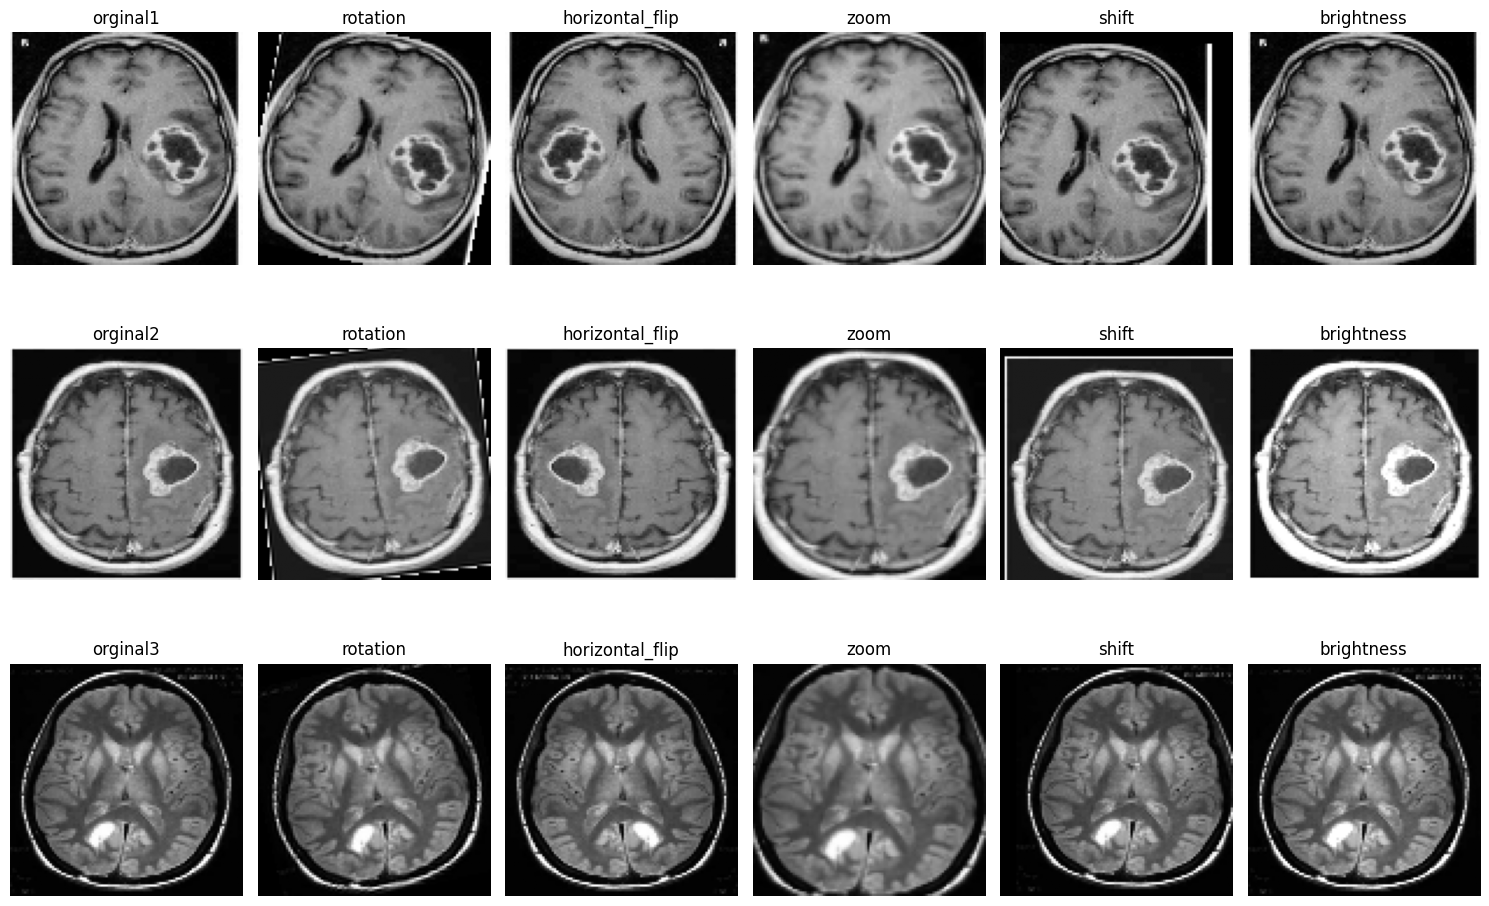

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
#orginal image
for i in range(3):
  plt.subplot(3,6,i*6+1)
  plt.imshow(data[i],cmap="gray")
  plt.title(f"orginal{i+1}")
  plt.axis("off")

  #show augmented
  original_img =data[i]
  for j,(aug_func,aug_name)in enumerate(zip(augmentation_functions,augmentation_names)):
    plt.subplot(3,6,i*6+j+2)
    aug_img=aug_func(original_img.copy())
    plt.imshow(aug_img,cmap="gray")
    plt.title(f"{aug_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()




In [ ]:
#normalize and reshape
combined_data=np.array(combined_data)/255.0
combined_data=np.reshape(combined_data,(combined_data.shape[0],img_size,img_size,1))
combined_target=np.array(combined_target)

print(f"Final data shape: {combined_data.shape}")
print(f"final data Shape: {combined_target.shape}")

Final data shape: (498, 100, 100, 1)
final data Shape: (498,)


In [ ]:
from tensorflow.keras.utils import to_categorical
new_target=to_categorical(combined_target)
print(f"one-hot encoded target shape: {new_target}")

one-hot encoded target shape: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(combined_data,new_target,test_size=0.1,random_state=42)

print(f"training set size: {x_train.shape[0]}")
print(f"testing set size: {x_test.shape[0]}")
print(f"shape of an image in train set:{x_train[0].shape}")
print(f"shape of an image in test set:{x_test[0].shape}")

training set size: 448
testing set size: 50
shape of an image in train set:(100, 100, 1)
shape of an image in test set:(100, 100, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,Dropout
from tensorflow.keras.layers import Conv2D,MaxPooling2D

In [ ]:
model=Sequential()

model.add(Conv2D(200,(3,3),input_shape=combined_data.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(100,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation="relu"))
model.add(Dense(2,activation="softmax"))

print("model architecture:")

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 200)    │         2,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 98, 98, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 100)    │       180,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 47, 47, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52900)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │     2,645,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,827,252 (10.79 MB)

 Trainable params: 2,827,252 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stoping=EarlyStopping(monitor="val_accuracy",patience=3,restore_best_weights=True,verbose=1)

In [ ]:
print("Starting model training...")
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,validation_split=0.2,batch_size=32,callbacks=[early_stoping])
#why validation split again already split xtrain and  xtest?
print("Trianing completed!!")

Starting model training...
Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.6370 - loss: 0.7791 - val_accuracy: 0.8000 - val_loss: 0.5585
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7271 - loss: 0.5188 - val_accuracy: 0.7800 - val_loss: 0.5345
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7943 - loss: 0.4687 - val_accuracy: 0.7600 - val_loss: 0.5226
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8245 - loss: 0.4175 - val_accuracy: 0.7800 - val_loss: 0.4510
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.
Trianing completed!!


In [ ]:


y_predict=model.predict(x_test)
y_predict_classes=np.argmax(y_predict,axis=1)
y_actual=np.argmax(y_test,axis=1)
print(y_predict_classes)
print(y_actual)

print(f"Prediction probabilities shape: {y_predict.shape}")
print(f"Predicted classes shape: {y_predicted_classes.shape}")
print(f"Actual classes shape: {y_actual.shape}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
[1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0
 0 1 1 1 1 0 1 0 0 0 1 0 1]
[1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1
 1 1 1 1 1 0 1 0 0 1 1 0 1]
Prediction probabilities shape: (50, 2)


NameError: name 'y_predicted_classes' is not defined